<a href="https://colab.research.google.com/github/tngym/interpretableNLP/blob/master/irm_cmnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# https://github.com/facebookresearch/InvariantRiskMinimization/blob/6aad47e689913b9bdad05880833530a5edac389e/code/colored_mnist/main.py
import argparse
import numpy as np
import torch
from torchvision import datasets
from torch import nn, optim, autograd

In [0]:
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
parser = argparse.ArgumentParser(description='Colored MNIST')
parser.add_argument('--hidden_dim', type=int, default=256)
parser.add_argument('--l2_regularizer_weight', type=float,default=0.001)
parser.add_argument('--lr', type=float, default=0.001)
parser.add_argument('--n_restarts', type=int, default=10)
parser.add_argument('--penalty_anneal_iters', type=int, default=100)
parser.add_argument('--penalty_weight', type=float, default=10000.0)
parser.add_argument('--steps', type=int, default=501)
parser.add_argument('--grayscale_model', action='store_true')

_StoreTrueAction(option_strings=['--grayscale_model'], dest='grayscale_model', nargs=0, const=True, default=False, type=None, choices=None, help=None, metavar=None)

In [0]:
# https://github.com/facebookresearch/InvariantRiskMinimization/blob/6aad47e689913b9bdad05880833530a5edac389e/code/colored_mnist/reproduce_paper_results.sh#L10-L27
import re
args = """--hidden_dim=390 \
  --l2_regularizer_weight=0.00110794568 \
  --lr=0.0004898536566546834 \
  --penalty_anneal_iters=190 \
  --penalty_weight=91257.18613115903 \
  --steps=501
"""
args = re.split("\s+|=", args)
args = [e for e in args if e]
flags = parser.parse_args(args=args)

In [4]:
print('Flags:')
for k,v in sorted(vars(flags).items()):
  print("\t{}: {}".format(k, v))

Flags:
	grayscale_model: False
	hidden_dim: 390
	l2_regularizer_weight: 0.00110794568
	lr: 0.0004898536566546834
	n_restarts: 10
	penalty_anneal_iters: 190
	penalty_weight: 91257.18613115903
	steps: 501


In [0]:
# 元のコードでは 10 回回して平均をとっているがとりあえず 1 回回す
restart = 0

In [0]:
# Load MNIST, make train/val splits, and shuffle train set examples

mnist = datasets.MNIST('~/datasets/mnist', train=True, download=True)
mnist_train = (mnist.data[:50000], mnist.targets[:50000])
mnist_val = (mnist.data[50000:], mnist.targets[50000:])

rng_state = np.random.get_state()
np.random.shuffle(mnist_train[0].numpy())
np.random.set_state(rng_state)
np.random.shuffle(mnist_train[1].numpy())

In [0]:
# Build environments

def make_environment(images, labels, e):
  # 二値ラベルを付けるための関数
  def torch_bernoulli(p, size):
    return (torch.rand(size) < p).float()
  def torch_xor(a, b):
    return (a-b).abs() # Assumes both inputs are either 0 or 1
  # 2x subsample for computational convenience
  images = images.reshape((-1, 28, 28))[:, ::2, ::2]
  # Assign a binary label based on the digit; flip label with probability 0.25
  labels = (labels < 5).float()
  labels = torch_xor(labels, torch_bernoulli(0.25, len(labels)))
  # Assign a color based on the label; flip the color with probability e
  colors = torch_xor(labels, torch_bernoulli(e, len(labels)))
  # Apply the color to the image by zeroing out the other color channel
  images = torch.stack([images, images], dim=1)
  images[torch.tensor(range(len(images))), (1-colors).long(), :, :] *= 0
  return {
    'images': (images.float() / 255.).cuda(),
    'labels': labels[:, None].cuda()
  }

envs = [
  make_environment(mnist_train[0][::2], mnist_train[1][::2], 0.2),  # [::2] は 1 個飛ばし
  make_environment(mnist_train[0][1::2], mnist_train[1][1::2], 0.1),
  make_environment(mnist_val[0], mnist_val[1], 0.9)
]

In [62]:
print("元の画像")
display(mnist_train[0].shape)
display(mnist_val[0].shape)
print("色付き画像：色の分だけ次元が増えている")
display(envs[0]["images"].shape)
display(envs[2]["images"].shape)

元の画像


torch.Size([50000, 28, 28])

torch.Size([10000, 28, 28])

色付き画像：色の分だけ次元が増えている


torch.Size([25000, 2, 14, 14])

torch.Size([10000, 2, 14, 14])

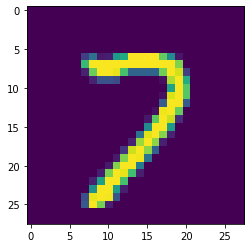

In [58]:
# 元の画像
plt.imshow(mnist_train[0][100].numpy())

CMNIST, env=1 の画像

- 元の数字（0~9）と二値のラベル(x<5 or x>=5) の間に 25% の noise が乗っているので数字とラベルはほとんど対応していないように見える
- 一方でラベルと色（画像が左右どちらに表示されているか）は相関 90% なので label=1 なら 90% の確率で右に画像が表示されている

label: 1.0


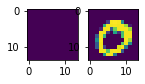

label: 1.0


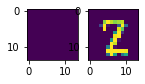

label: 1.0


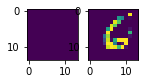

label: 1.0


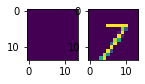

label: 0.0


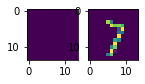

label: 0.0


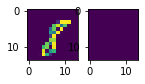

label: 0.0


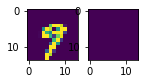

label: 1.0


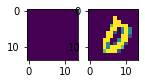

label: 0.0


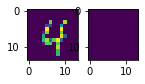

label: 0.0


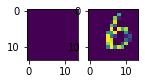

label: 1.0


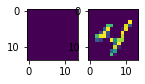

label: 1.0


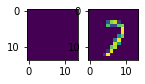

label: 1.0


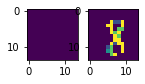

label: 1.0


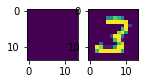

label: 0.0


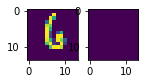

label: 1.0


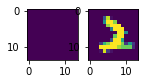

label: 1.0


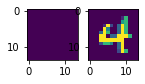

label: 1.0


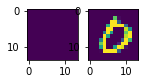

label: 1.0


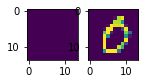

label: 1.0


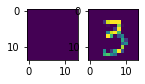

In [68]:
def _show(img_id, env_id):
  print(f"label: {envs[env_id]['labels'][img_id][0]}")
  fig, axs = plt.subplots(1, 2, figsize = (2, 2))
  axs[0].imshow(envs[env_id]["images"][img_id][0].cpu().numpy())
  axs[1].imshow(envs[env_id]["images"][img_id][1].cpu().numpy())
  plt.show();

for i in range(100, 120):
  _show(i, 1)

In [0]:
# Define and instantiate the model

class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    if flags.grayscale_model:
      lin1 = nn.Linear(14 * 14, flags.hidden_dim)
    else:
      lin1 = nn.Linear(2 * 14 * 14, flags.hidden_dim)
    lin2 = nn.Linear(flags.hidden_dim, flags.hidden_dim)
    lin3 = nn.Linear(flags.hidden_dim, 1)
    for lin in [lin1, lin2, lin3]:
      nn.init.xavier_uniform_(lin.weight)
      nn.init.zeros_(lin.bias)
    self._main = nn.Sequential(lin1, nn.ReLU(True), lin2, nn.ReLU(True), lin3)
  def forward(self, input):
    if flags.grayscale_model:
      out = input.view(input.shape[0], 2, 14 * 14).sum(dim=1)
    else:
      out = input.view(input.shape[0], 2 * 14 * 14)
    out = self._main(out)
    return out

mlp = MLP().cuda()

IRM における penalty は以下で定義

In [0]:
# Define loss function helpers

def mean_nll(logits, y):
  return nn.functional.binary_cross_entropy_with_logits(logits, y)

def mean_accuracy(logits, y):
  preds = (logits > 0.).float()
  return ((preds - y).abs() < 1e-2).float().mean()

def penalty(logits, y):
  # これが IRM の一番の肝
  scale = torch.tensor(1.).cuda().requires_grad_()
  loss = mean_nll(logits * scale, y)
  grad = autograd.grad(loss, [scale], create_graph=True)[0]  # 高階微分計算のため create_graph=True
  return torch.sum(grad**2)


計算は一瞬で終わる

In [73]:
# Train loop

def pretty_print(*values):
  col_width = 13
  def format_val(v):
    if not isinstance(v, str):
      v = np.array2string(v, precision=5, floatmode='fixed')
    return v.ljust(col_width)
  str_values = [format_val(v) for v in values]
  print("   ".join(str_values))

optimizer = optim.Adam(mlp.parameters(), lr=flags.lr)


pretty_print('step', 'train nll', 'train acc', 'train penalty', 'test acc')


for step in range(flags.steps):
  for env in envs:
    # 各 env で Fwd 計算して loss 計算
    logits = mlp(env['images'])
    env['nll'] = mean_nll(logits, env['labels'])
    env['acc'] = mean_accuracy(logits, env['labels'])
    env['penalty'] = penalty(logits, env['labels'])

  train_nll = torch.stack([envs[0]['nll'], envs[1]['nll']]).mean()
  train_acc = torch.stack([envs[0]['acc'], envs[1]['acc']]).mean()
  train_penalty = torch.stack([envs[0]['penalty'], envs[1]['penalty']]).mean()

  weight_norm = torch.tensor(0.).cuda()
  for w in mlp.parameters():
    weight_norm += w.norm().pow(2)

  loss = train_nll.clone()
  loss += flags.l2_regularizer_weight * weight_norm  # loss に weight normalization も追加
  penalty_weight = (flags.penalty_weight 
      if step >= flags.penalty_anneal_iters else 1.0)
  loss += penalty_weight * train_penalty  # loss に IRM の penalty 項も追加、最初はものすごく小さな penalty_weight
  if penalty_weight > 1.0:
    # Rescale the entire loss to keep gradients in a reasonable range
    loss /= penalty_weight

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  
  test_acc = envs[2]['acc']
  if step % 100 == 0:
    pretty_print(
      np.int32(step),
      train_nll.detach().cpu().numpy(),
      train_acc.detach().cpu().numpy(),
      train_penalty.detach().cpu().numpy(),
      test_acc.detach().cpu().numpy()
    )

step            train nll       train acc       train penalty   test acc     
0               0.70539         0.48702         0.00032         0.49020      
100             0.39081         0.84696         0.00441         0.10520      
200             0.37333         0.84126         0.00270         0.19690      
300             0.57244         0.70416         2.50350e-08     0.66160      
400             0.57274         0.70414         7.75488e-10     0.66350      
500             0.57243         0.70444         7.57660e-10     0.66360      
